In [214]:
import networkx as nx
import os
import networkx as nx
from node2vec import Node2Vec
from helper_functions import read_net
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from collections import Counter
import math
import json

In [45]:
filename = "wikilinks_ids"
folder = os.path.join("..", "data")

In [46]:
G = read_net(folder, filename)

In [49]:
pr = nx.pagerank(G, alpha=0.9)

In [143]:
sizes = np.array(list(pr.values()))

In [144]:
colors = np.array(list(pr.values()))

In [145]:
h = 50
l = 0

In [146]:
sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes)) * (h - l) + l

In [147]:
sizes = sizes**2

In [128]:
count = 0
for i in sizes:
    if i > 0:
        count += 1

In [66]:
EMBEDDING_FILENAME = os.path.join("..", "data", "wikilinks.emb")

In [67]:
embeddings = np.genfromtxt(EMBEDDING_FILENAME, delimiter=',')

In [70]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

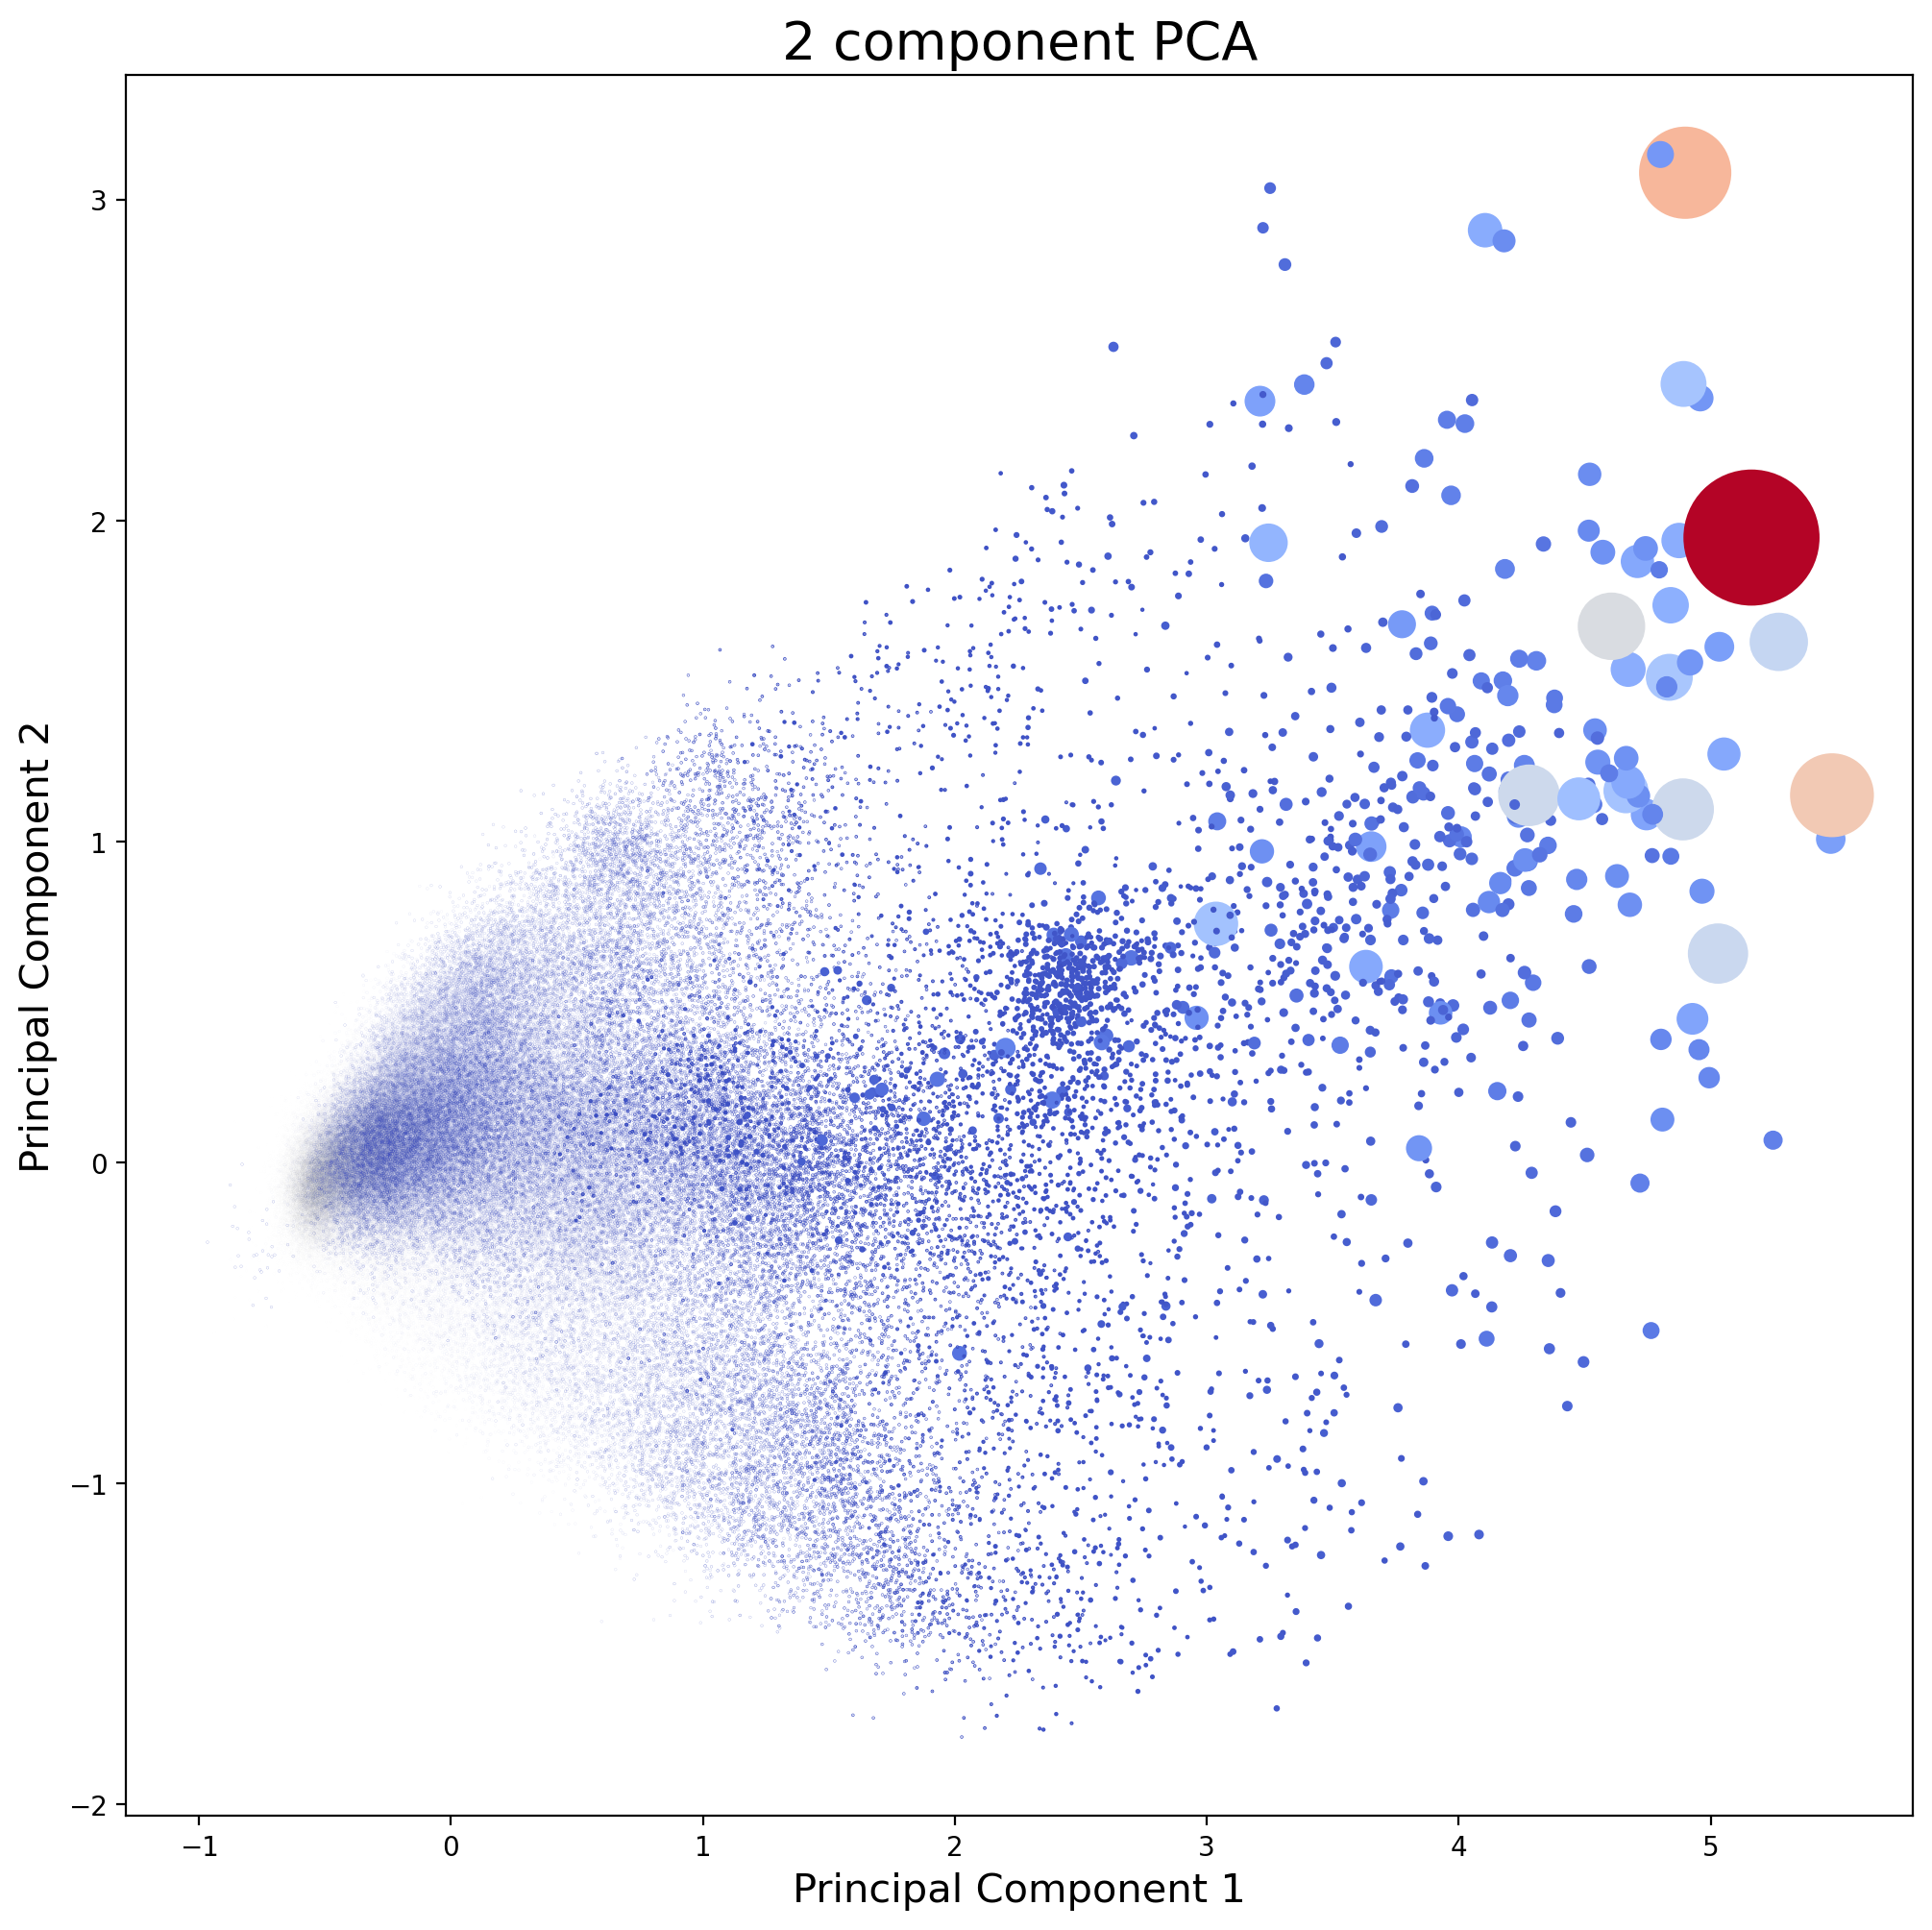

In [153]:
fig = plt.figure(figsize = (12,12), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=sizes, c=colors, cmap=plt.cm.coolwarm)
plt.savefig("../img/pca.png", bbox_inches="tight", dpi=200)

In [154]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(embeddings)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

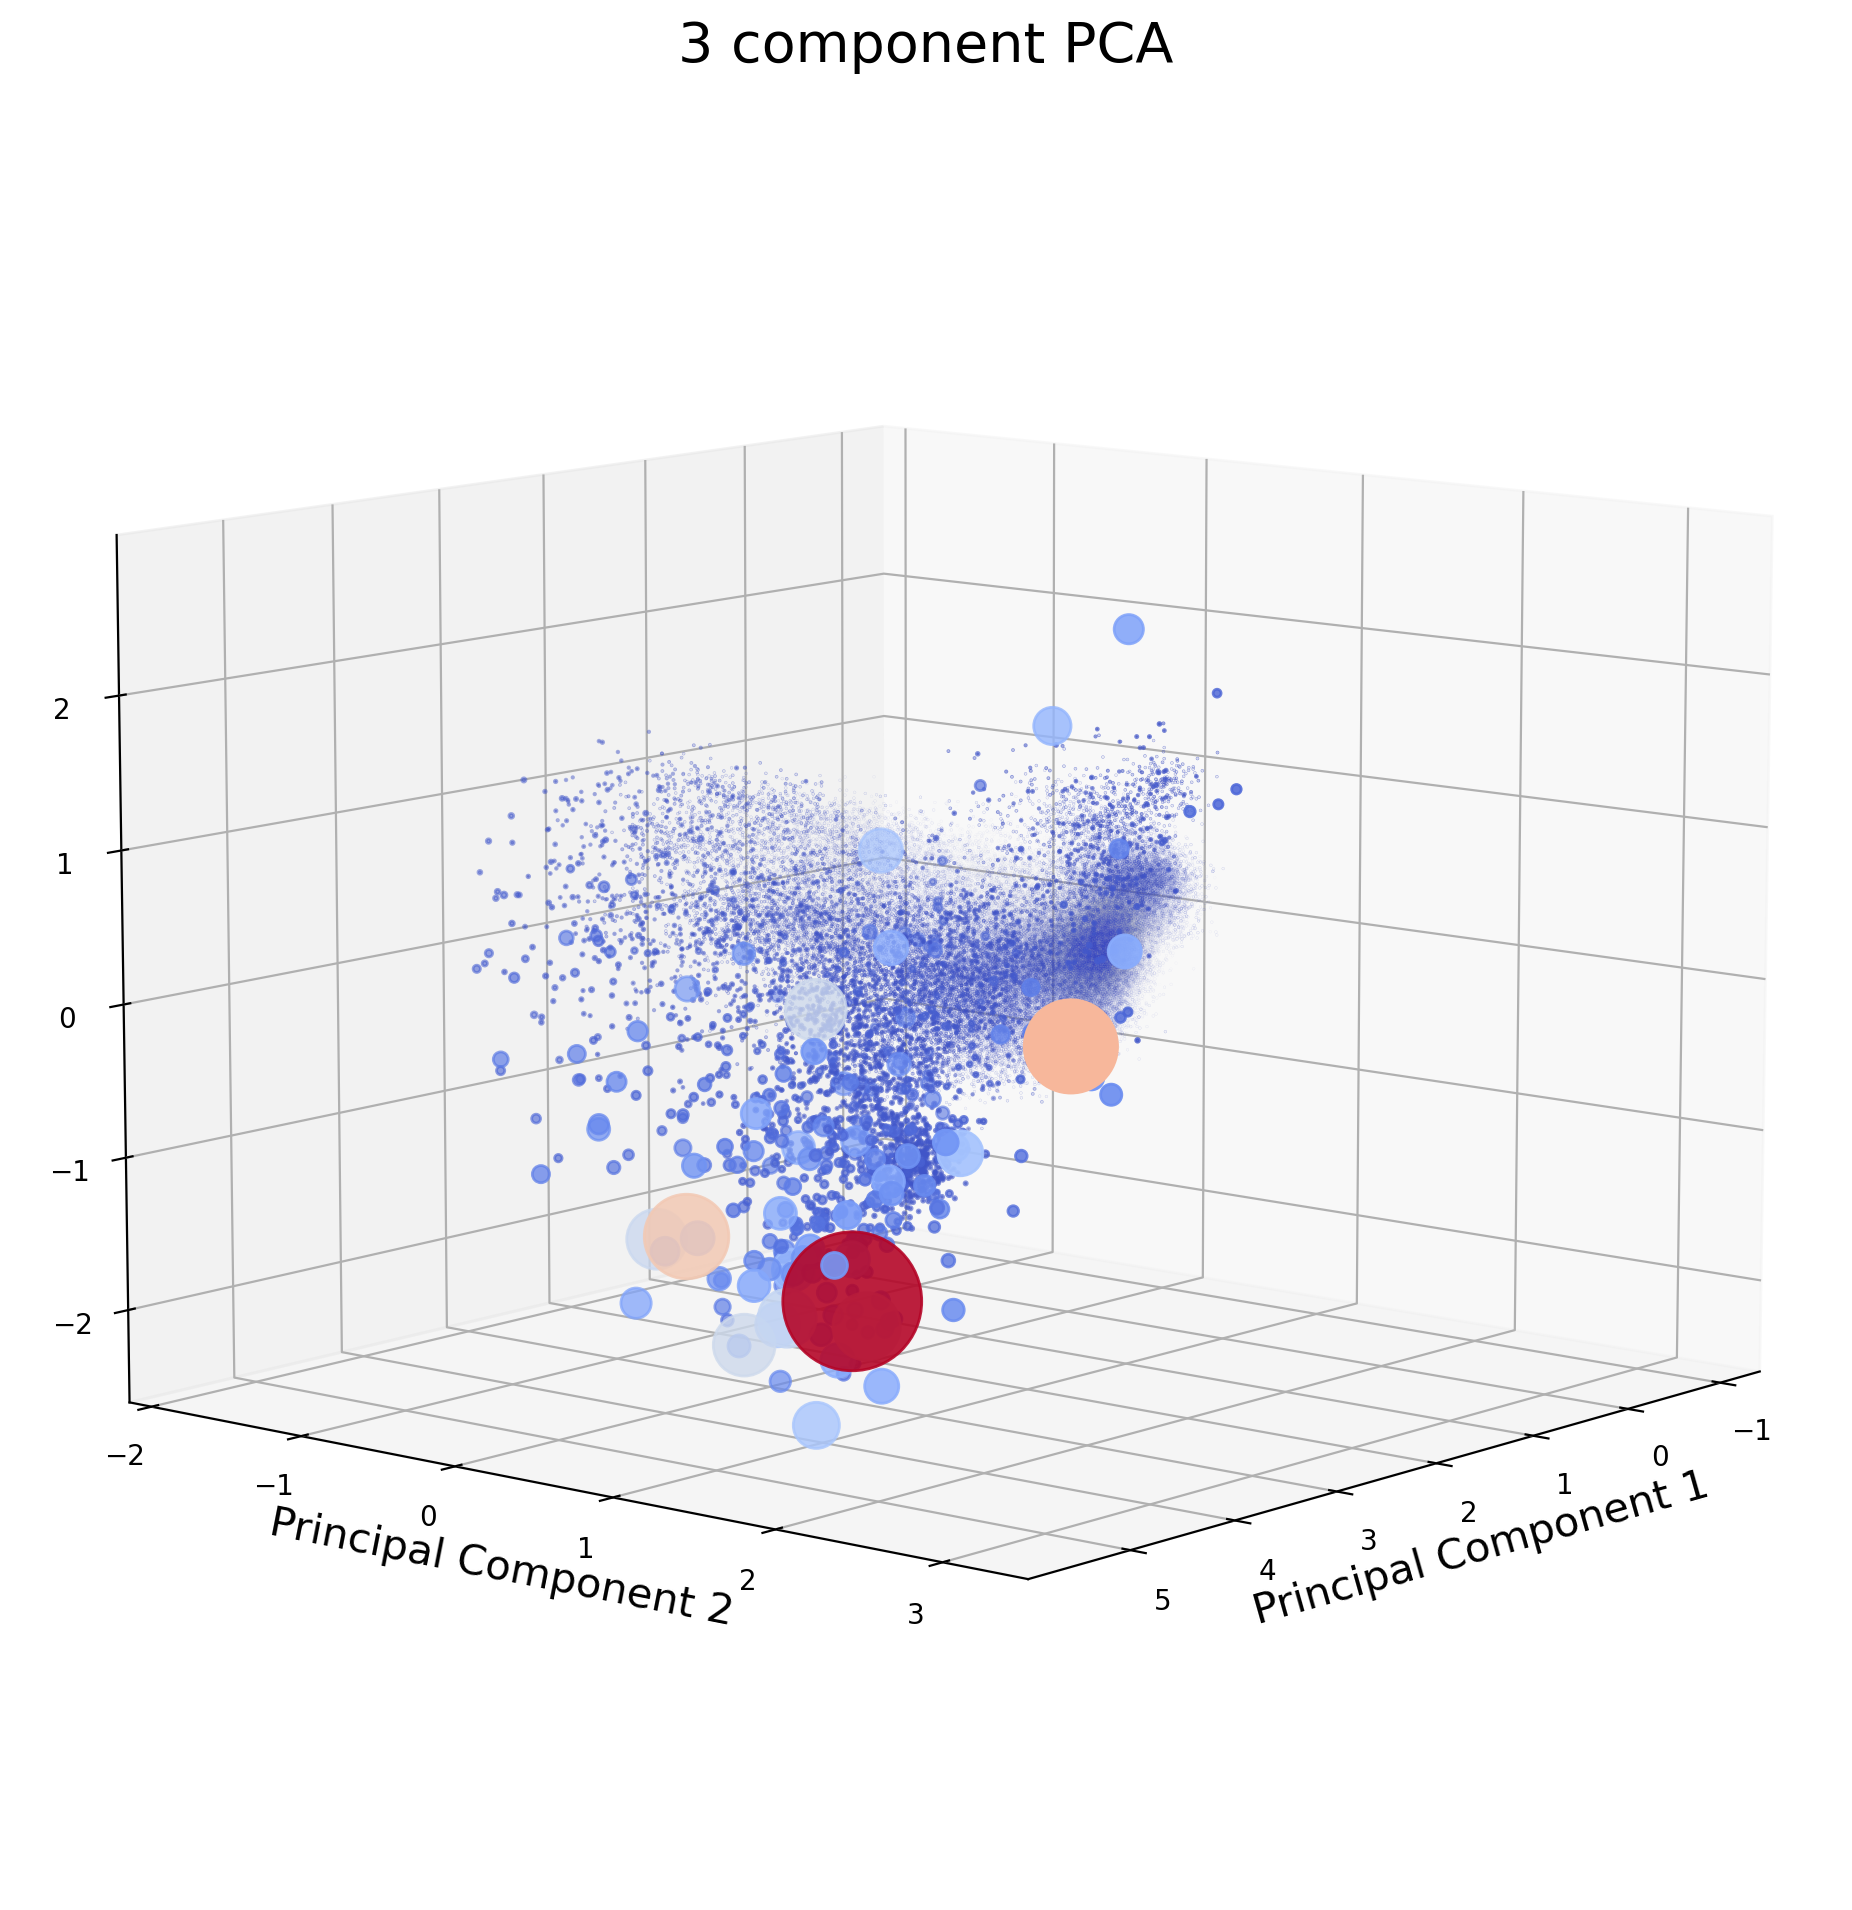

In [166]:
fig = plt.figure(figsize = (12,12), facecolor='white', dpi=200)
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], principalDf['principal component 3'], s=sizes, c=colors, cmap=plt.cm.coolwarm)
ax.view_init(10, 40)
plt.savefig("../img/pca3d.png", bbox_inches="tight", dpi=200)

In [168]:
def calculate_degrees(G, degree_list):
    degree_list = sorted([i for i in degree_list if i != 0])

    degree_dict = Counter(degree_list)
    k = list(degree_dict.keys())
    Pk = [i / G.number_of_nodes() for i in degree_dict.values()]

    return k, Pk


def calculate_y(G, degrees, k_min = 1):
    n = 0
    sum_k = 0
    for _, k in degrees:
        if k >= k_min:
            sum_k += math.log(k / (k_min - 1/2))
            n += 1
    return 1 + n/sum_k

In [222]:
def plot_distributions(G, filename):
    # Calculate all degrees
    x, y = calculate_degrees(G, list(dict(G.degree).values()))
    x_in, y_in = calculate_degrees(G, list(dict(G.in_degree).values()))
    x_out, y_out = calculate_degrees(G, list(dict(G.out_degree).values()))

    fig, axs = plt.subplots(2, 2, figsize=(15,8), dpi=300, facecolor="white")

    color = ["#ff71ce", "#01cdfe", "#05ffa1", "#b967ff", "#fffb96"]

    # All degrees
    axs[0][0].loglog(x, y, "o", label='Wikilinks', color=color[0], alpha=0.7)
    axs[0][1].loglog(x, y, "o", label='Wikilinks', color=color[0], alpha=0.7)

    # Seperated degrees
    axs[0][0].loglog(x_in, y_in, "o", label='Wikilinks indegree', color=color[1], alpha=0.7)
    axs[1][0].loglog(x_in, y_in, "o", label='Wikilinks indegree', color=color[1], alpha=0.7)
    
    axs[0][0].loglog(x_out, y_out, "o", label='Wikilinks outdegree', color=color[2], alpha=0.7)
    axs[1][1].loglog(x_out, y_out, "o", label='Wikilinks outdegree', color=color[2], alpha=0.7)

    # Set labels and legend
    # axs = [ax11]
    for i in axs:
        for ax in i:
            ax.set_xlabel("k")
            ax.set_ylabel("Pk")
            ax.legend()

    # Saving and showing fig
    plt.subplots_adjust(wspace=0.15, hspace=0.1)
    plt.savefig("../img/" + filename, facecolor='white', bbox_inches="tight")
    plt.show()

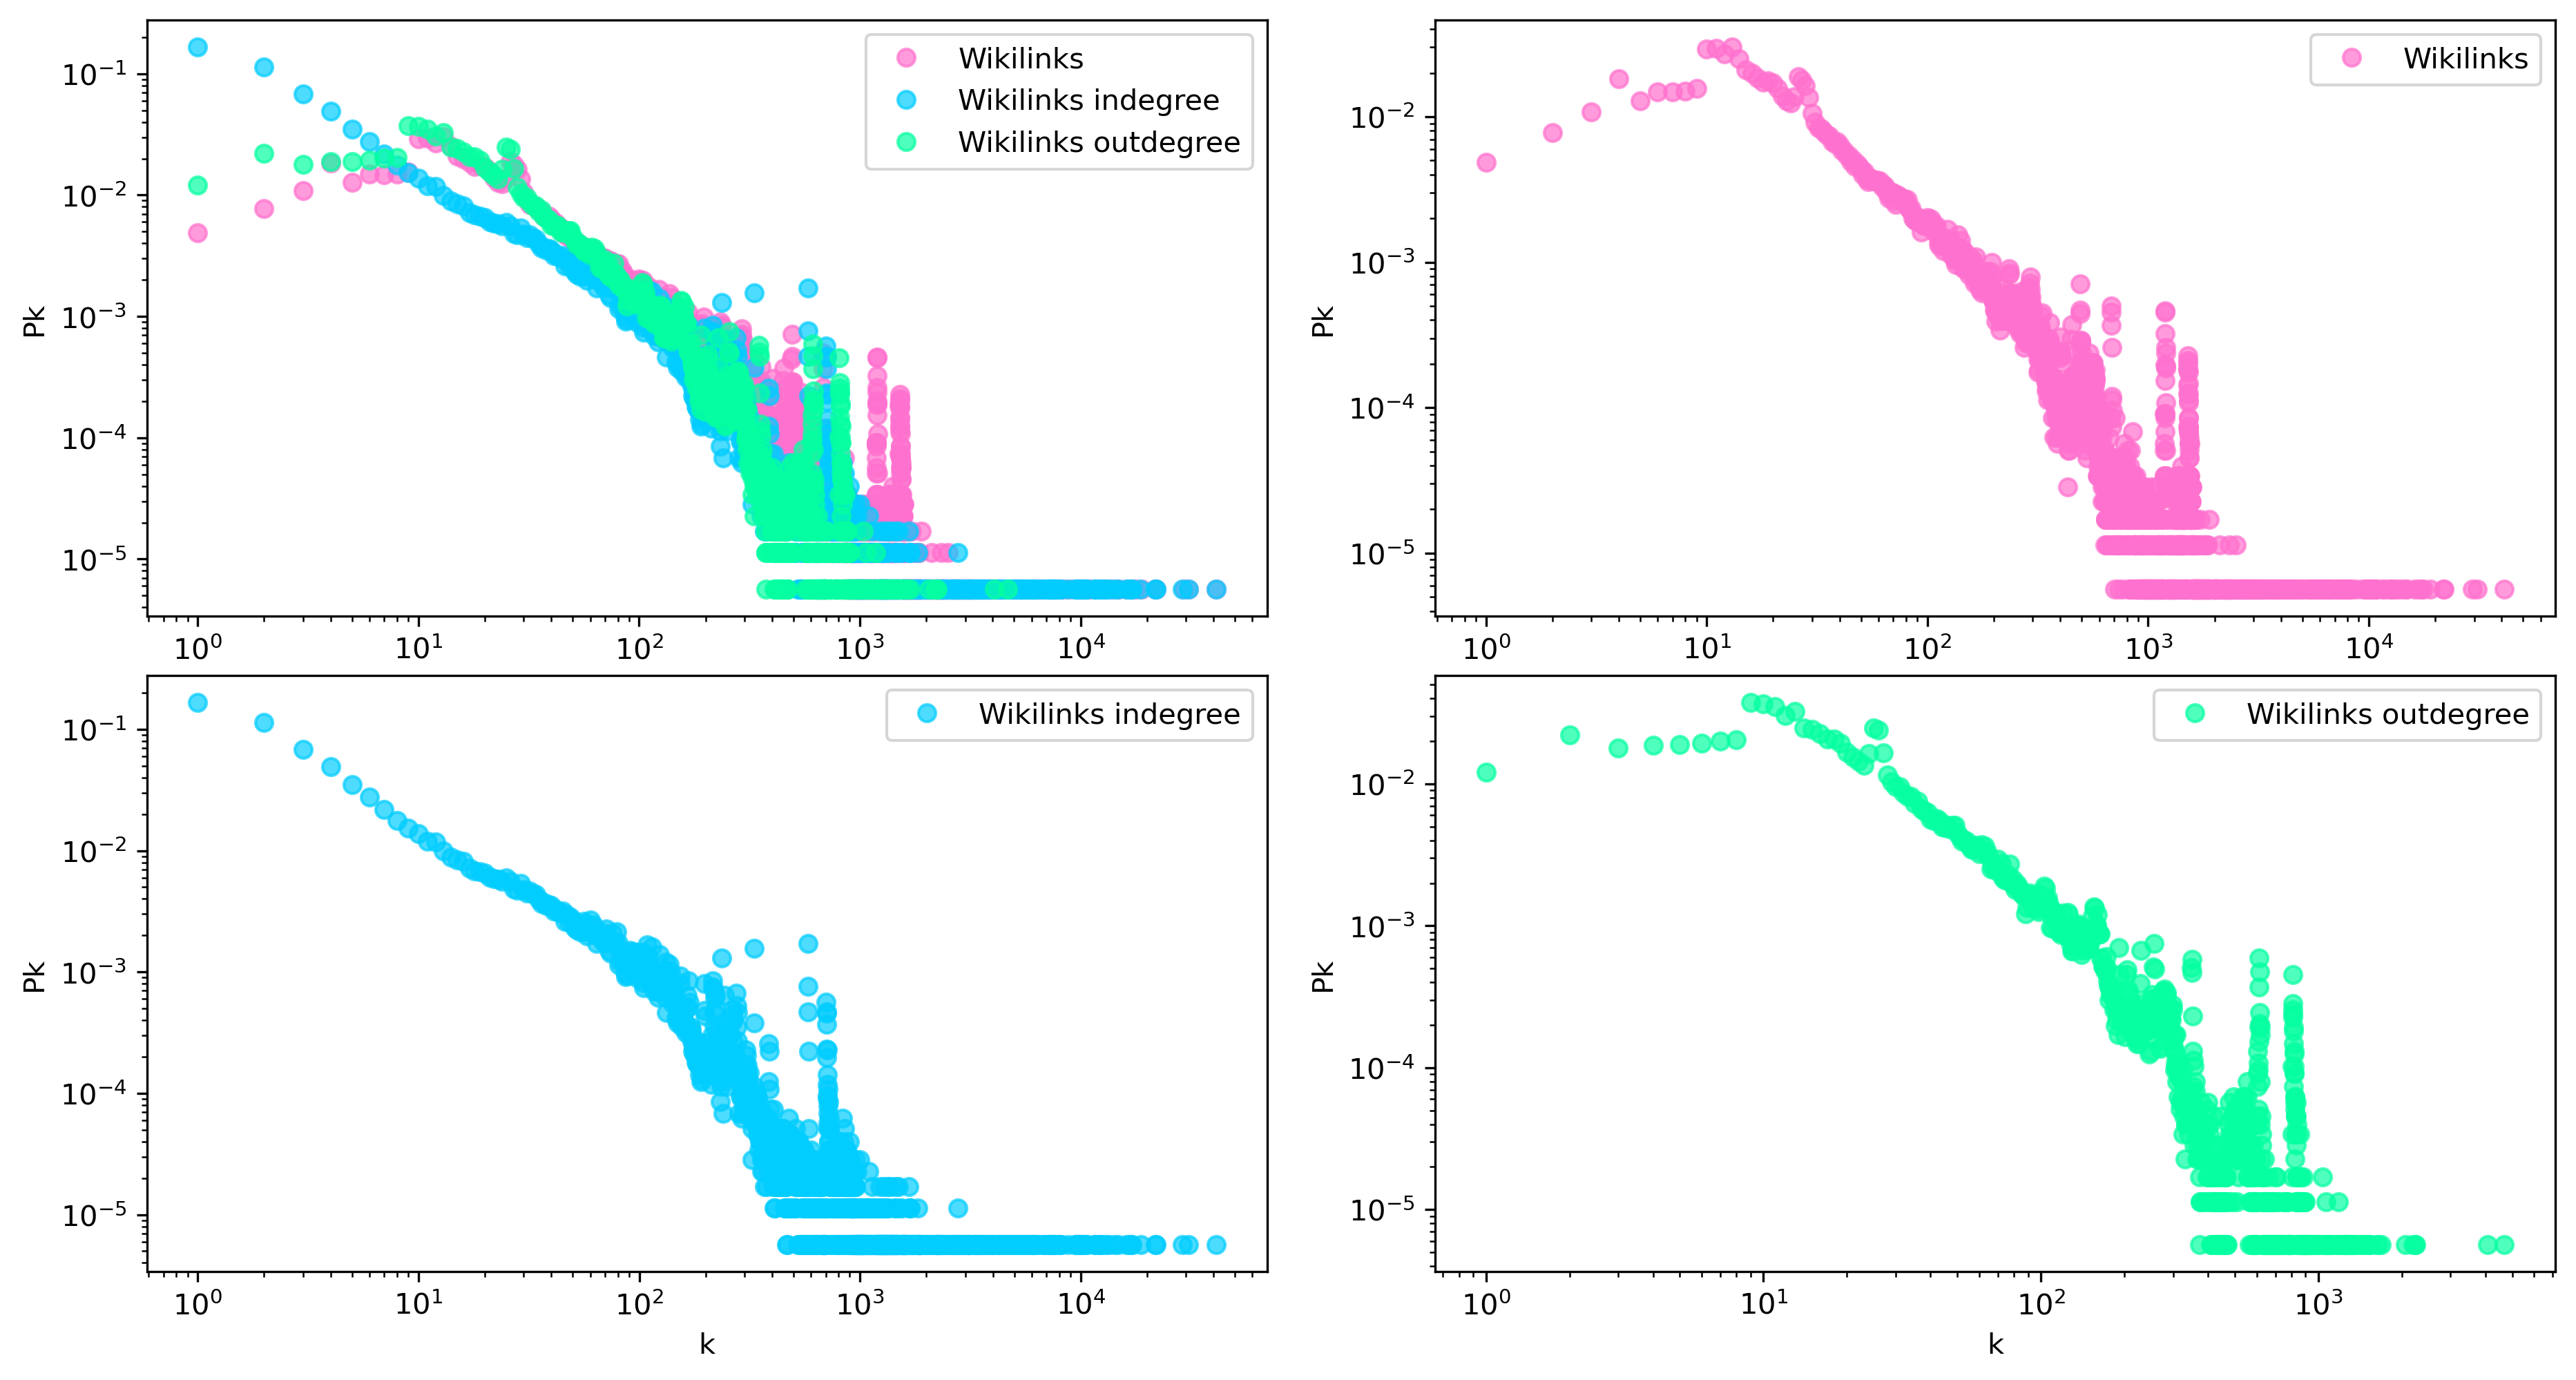

In [223]:
plot_distributions(G, "distribution.png")

In [232]:
G1 = G.copy()

In [233]:
def truncate_network(G, cutoff_views):
    with open("../data/views_map.json", "r") as f:
        views = json.loads(f.read())
    views_set = set(views.keys())

    nodes_to_remove = []
    for node, label in G.nodes(data=True):
        if label["label"] in views_set:
            v = views[label["label"]]

            sum_views_of_page = 0
            for day in v:
                num_views = v[day]
                if num_views != None:
                    sum_views_of_page += num_views
            
            if sum_views_of_page < cutoff_views:
                nodes_to_remove.append(node)
    G.remove_nodes_from(nodes_to_remove)

In [234]:
truncate_network(G1, cutoff_views=5)

In [235]:
G1.number_of_nodes()

103562

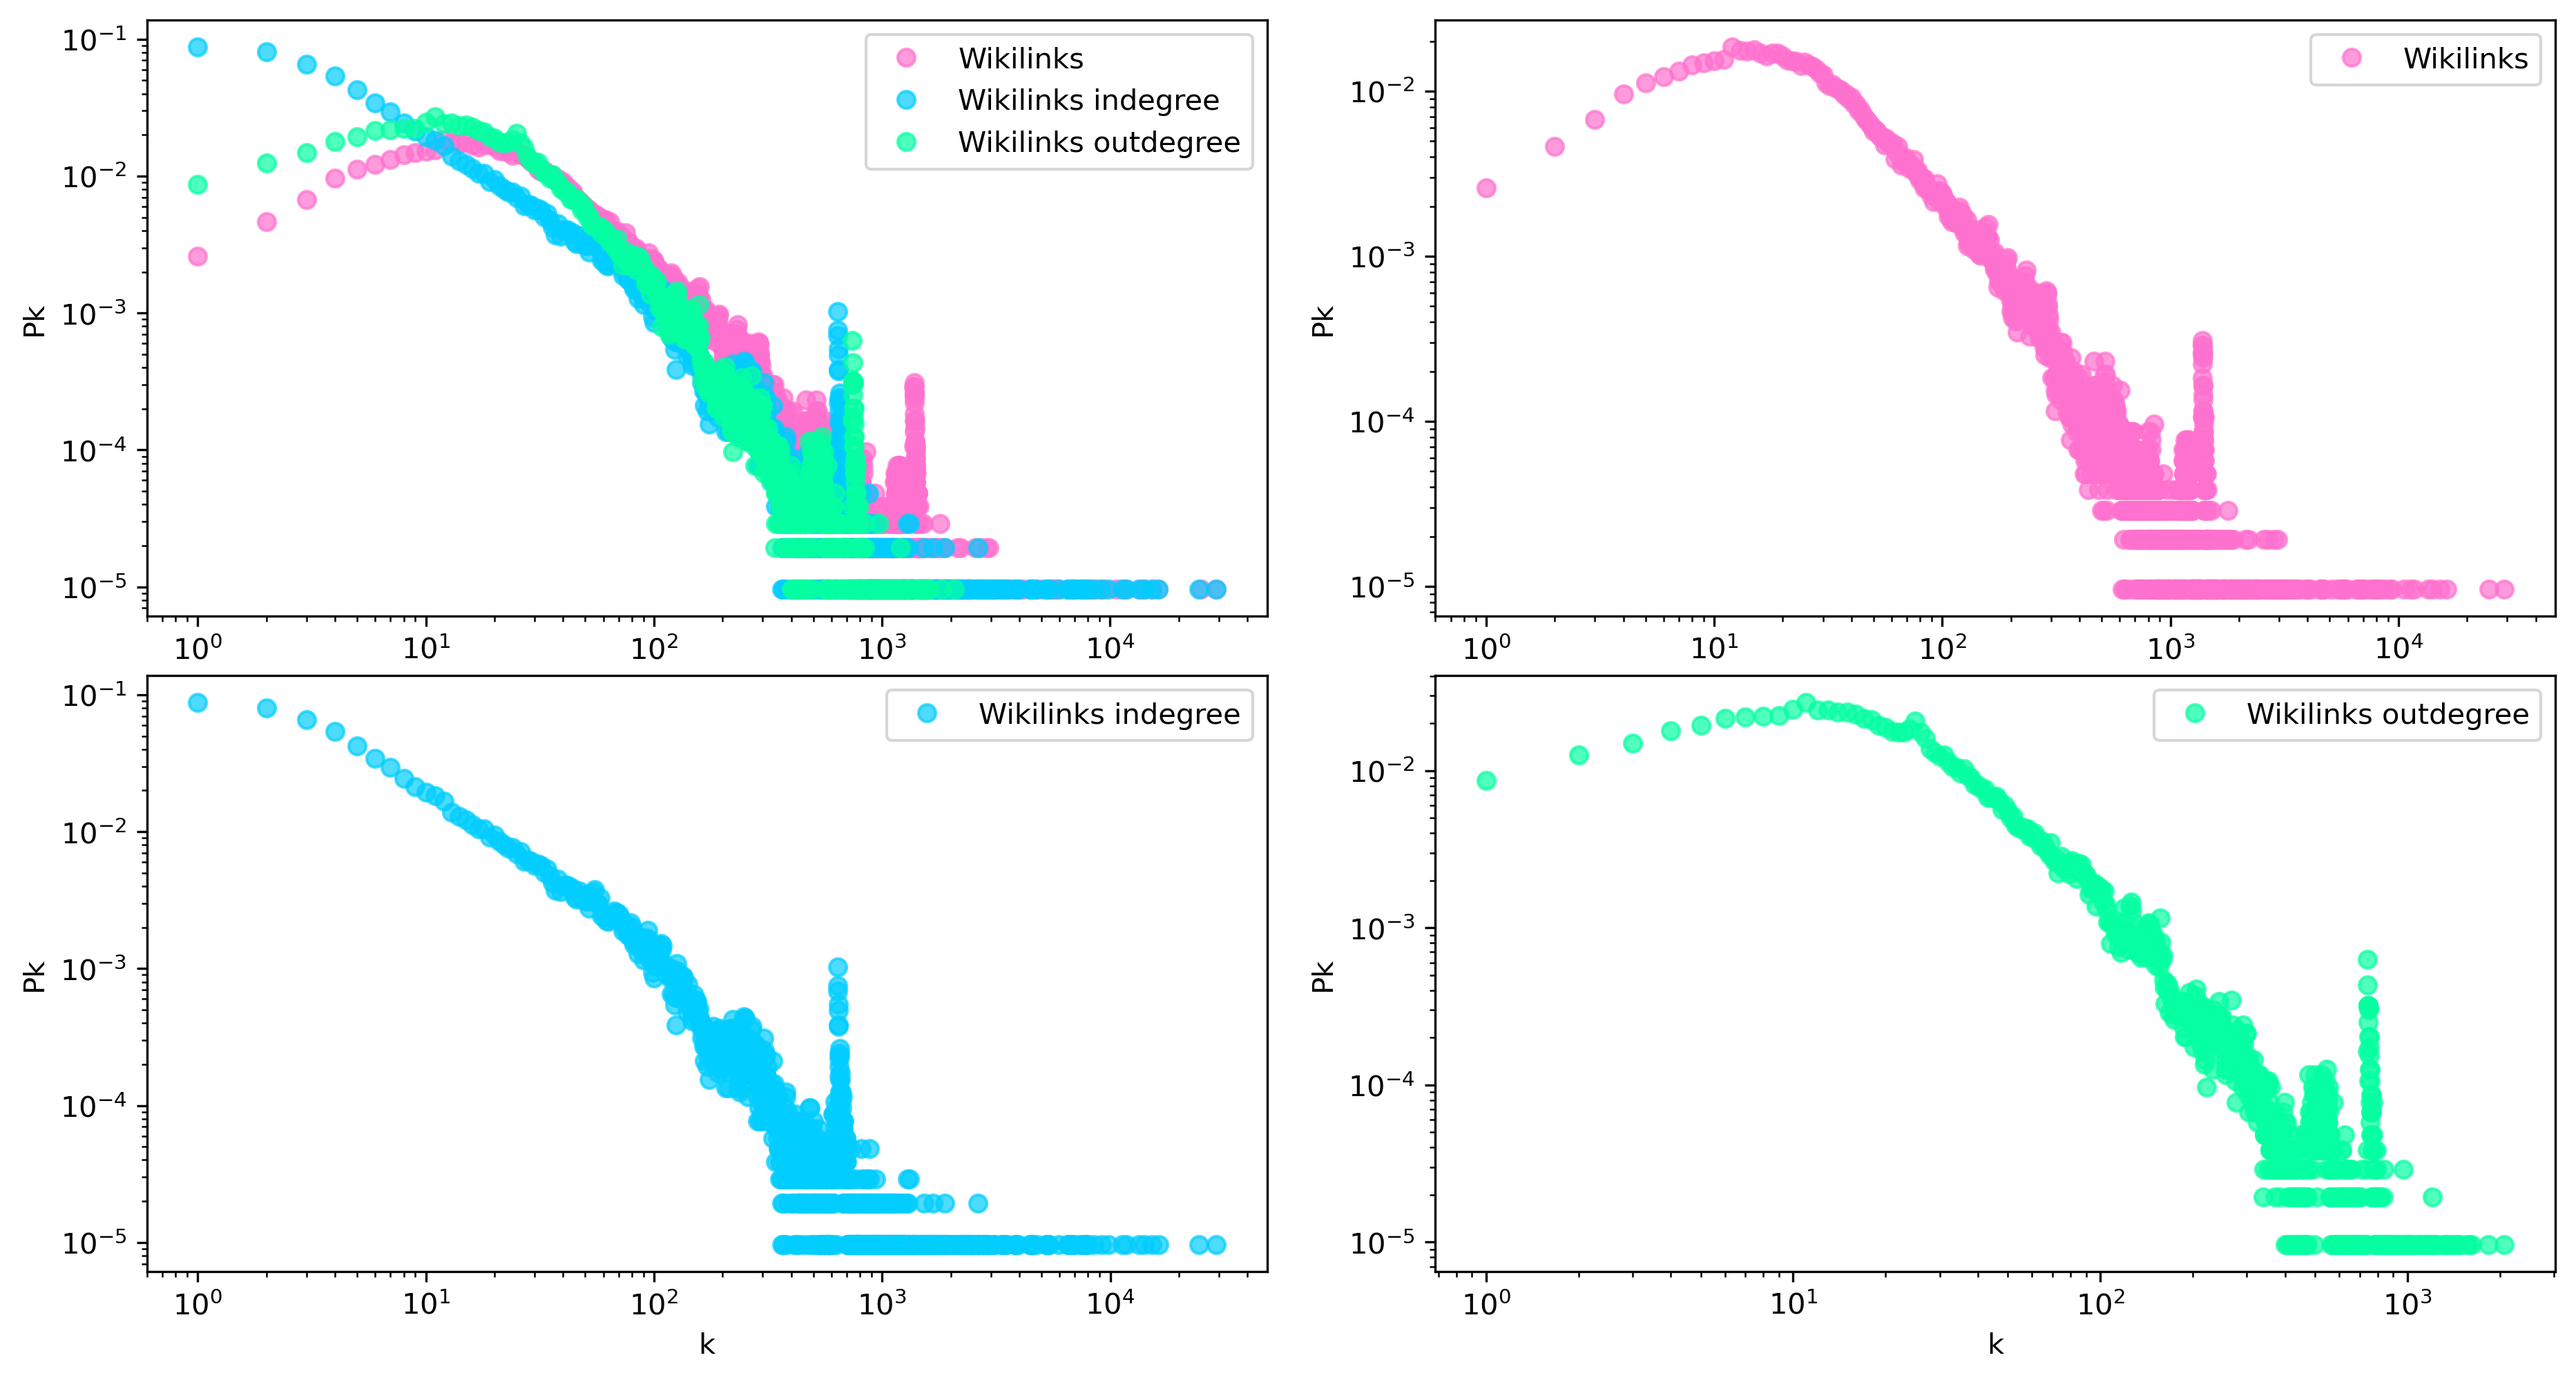

In [236]:
plot_distributions(G1, "distribution-truncated.png")